# **Heart Failure ML project**

Heart failure (HF) occurs when the heart is unable to pump enough blood to meet the body's needs. This condition is a significant subset of  **cardiovascular diseases**, which also include coronary heart diseases (heart attacks), cerebrovascular diseases (strokes), and other pathologies that together cause approximately **17 million people** globally each year.<br>

Applying machine learning to medical records can be instrumental in predicting patient survival, identifying patterns, and ranking features to understand risk factors, which may be challenging to detect through traditional medical evaluations.<br>

This project aims to leverage both **traditional machine learning models** and **graph-based models** to predict heart failure outcomes using the Heart Failure Clinical Records dataset from the UCI Machine Learning Repository.<br>

### Scope:

The project involves a thorough Exploratory Data Analysis (EDA) to understand the dataset, followed by data preprocessing to prepare for model training. The focus is on building, training, and evaluating both traditional machine learning models and graph-based models. Additionally, a feature selection process will be conducted to enhance model performance.<br>

### Goal:

The primary goal is to compare the predictive performance of traditional machine learning models (e.g., Logistic Regression, Random Forest, XGBoost) with a graph-based model (e.g., Graph Neural Network) for predicting heart failure outcomes.<br>

### Approach

* **Exploratory Data Analysis (EDA)**: Analyze the dataset structure, feature distributions, and relationships between variables.

* **Preprocessing**: Standardize features, handle class imbalance, and prepare data for model training.

* **Feature Selection**: Identify the most relevant features to improve model performance.

* **Model Building**: Train and evaluate traditional machine learning models and graph-based models.

* **Comparison and Analysis**: Evaluate model performance using metrics such as accuracy, precision, recall and F1-score. Visualize results and provide insights into model effectiveness.

<br>

The results are presented at the end of the notebook. ([click here to go to the end](#Results_and_conclusions))

### Index

*  [Exploratory Data Analysis](#Exploratory_data_analysis)
    * [Imports](#Imports)
    * [Dataset](#Dataset)
    * [Feature Distributions](#Feature_distributions)
    * [Standardization](#Standardization)
    * [Correlation Matrix](#Correlation_matrix)
    * [Feature Selection](#Feature_selection)
    * [Class Imbalance](#Class_imbalance)
<!--empty line here-->
*  [Model Building](#Model_building)
    * [Traditional Machine Learning Models](#Traditional_ML_models)
        * [Logistic Regression](#Logistic_regression)
        * [Random Forest](#Random_forest)
        * [XGBoost](#XGBoost)
    * [Graph-Based Models](#Graph_based_models)
        * [Graph Construction](#Graph_construction)
        * [Graph Neural Network (GCN)](#GCN)
<!--empty line here-->
*  [Results and Conclusions](#Results_and_conclusions)

# **Exploratory data analisys**

## Imports

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from scipy.stats import chi2

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import networkx as nx
from pyvis.network import Network

from torch_geometric.loader import DataLoader
import itertools
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors

##  Dataset

**Heart Failure Clinical Records Dataset** contains the medical records of 299 patients who had heart failure.<br>
The dataset contains 12 clinical features (binary and numerical), the *follow-up* period and the label `DEATH_EVENT` that indicates whether or not the patient has died.<br>
We can find some features strictly related to medical aspects like levels of enzymes, sodium, creatinine and platelets in the blood and others that are more common like age, sex or smoking.

[Dataset link](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records)

In [113]:
hf = pd.read_csv("heart_failure_clinical_records_dataset.csv")

| Feature  | Description | Units | Range |
| :------------- | :------------- | :------------- | :------------- |
| `age`   | Age of the patient | Years | (40, ..., 95) |
| `anaemia`  | Decrease of red blood cells or hemoglobin<br> (haematocrit levels were lower than 36%)  | Boolean  |  0, 1 |
| `creatinine_phosphokinase` | Level of the CPK enzyme in the blood | mcg/L | (23, ..., 7861) |
| `diabetes` | If the patient has diabetes | Boolean | 0, 1 |
| `ejection_fraction` | Percentage of blood leaving the heart<br> at each contraction | Percentage | (14, ..., 80) |
| `high_blood_pressure`  | If a patient has hypertension | Boolean | 0, 1 |
| `platelets` | Platelets in the blood | kiloplatelets/mL | (25.01, ..., 850.00) |
| `serum_creatinine` | Level of creatinine in the blood | mg/dL | (0.50, ..., 9.40) |
| `serum_sodium` | Level of sodium in the blood |  mEq/L | 114, ..., 148 |
| `sex` | Woman / Man | Binary | 0, 1 |
| `smoking` | If the patient smokes | Boolean | 0, 1 |
| `time` | Follow-up period | Days | (4, ..., 285) |
| `DEATH_EVENT` | If the patient died during the follow-up period |  Boolean | 0, 1 |

Let's represent the `platelets` as kiloplatelets/mL (The dataset has provided platelet counts in platelets/mL).

In [114]:
hf.platelets = hf.platelets/1000

Let's quickly view the top rows of the dataset:

In [115]:
hf.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265.00000,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263.35803,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162.00000,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210.00000,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327.00000,2.7,116,0,0,8,1


We'll shorten `creatinine_phosphokinase` to `CPK` for simplicity.

In [116]:
hf["CPK"] = hf["creatinine_phosphokinase"]
hf = hf.drop("creatinine_phosphokinase", axis=1)

## Feature distributions

In [117]:
numerical_features = ["age", "CPK", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
categorical_features = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]

First, we plot the **numerical** features, leaving out time since it's not used in the prediction. <br>
We use a **kdeplot** to show the distribution more clearly, along with a **boxplot**.

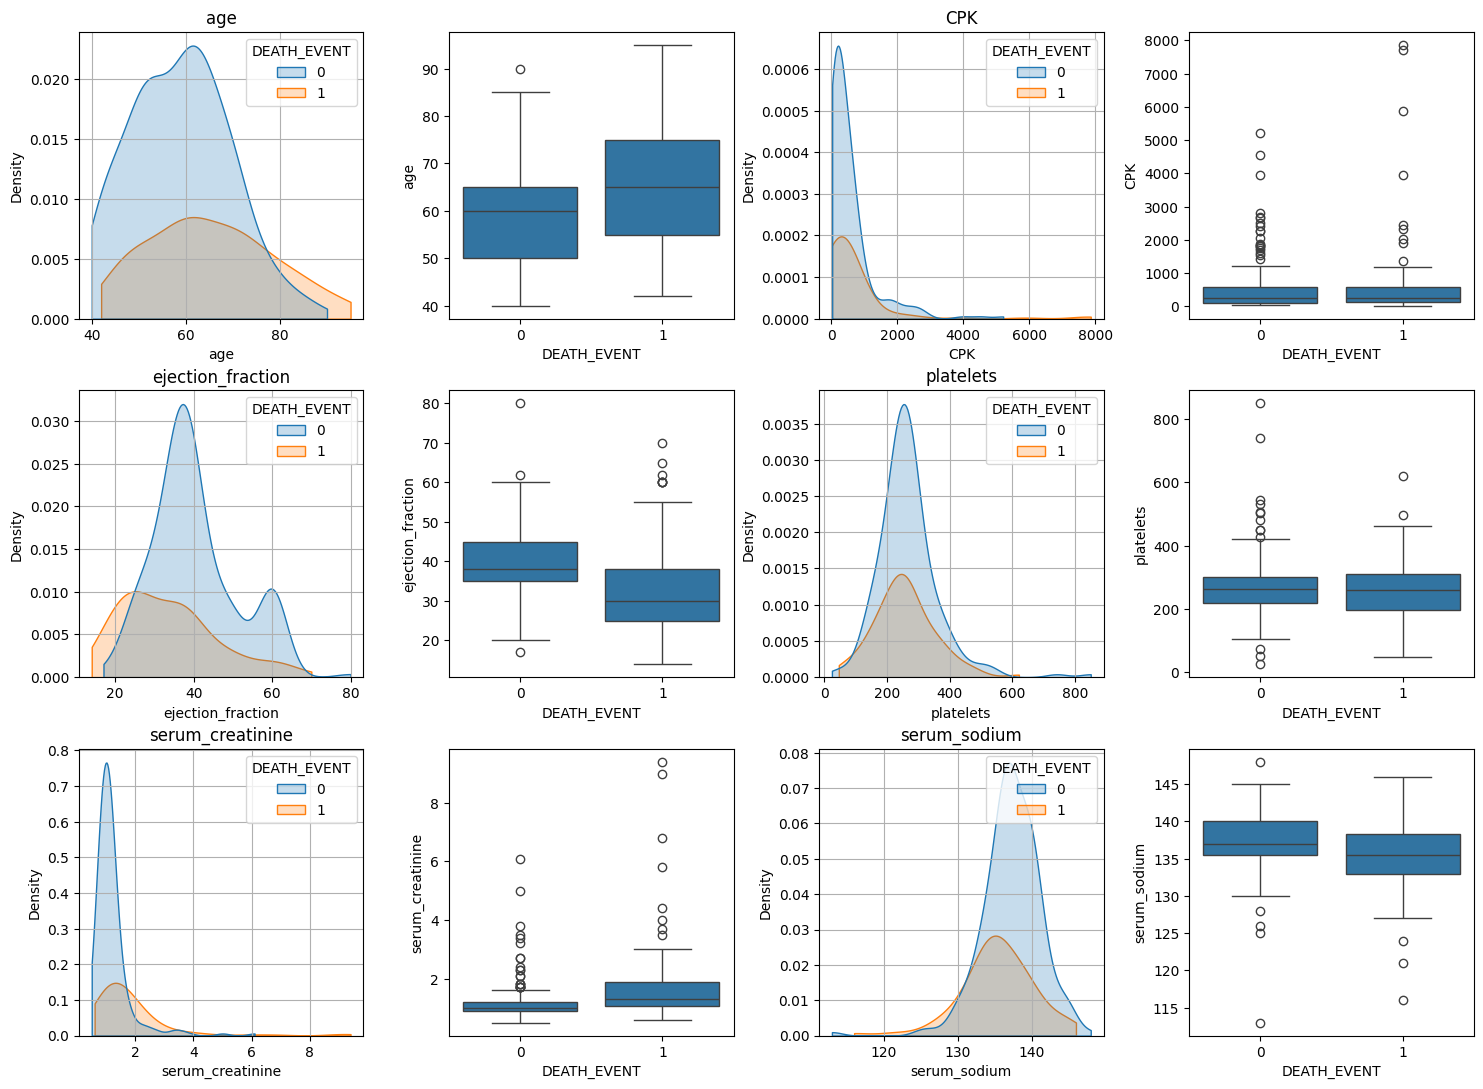

In [118]:
plt.figure(figsize=(18, 27))

num_rows = 6
num_cols = 4

for i, col in enumerate(numerical_features):

    plt.subplot(num_rows, num_cols, i*2+1)
    plt.subplots_adjust(hspace=0.25, wspace=0.3)
    plt.grid(True)
    plt.title(col)
    sns.kdeplot(data=hf, x=col, hue="DEATH_EVENT", fill=True, cut=0)
    
    plt.subplot(num_rows, num_cols, i*2+2)
    sns.boxplot(x="DEATH_EVENT", y=col, data=hf)

plt.show()

From the distribution plot of the features before normalization, the most informative ones appear to be `ejection_fraction` and `serum_creatinine`. <br>
This observation is supported by the original paper by Chicco and Jurman, where the analysis was focused on these two features.

We will plot also the **categorical** features:

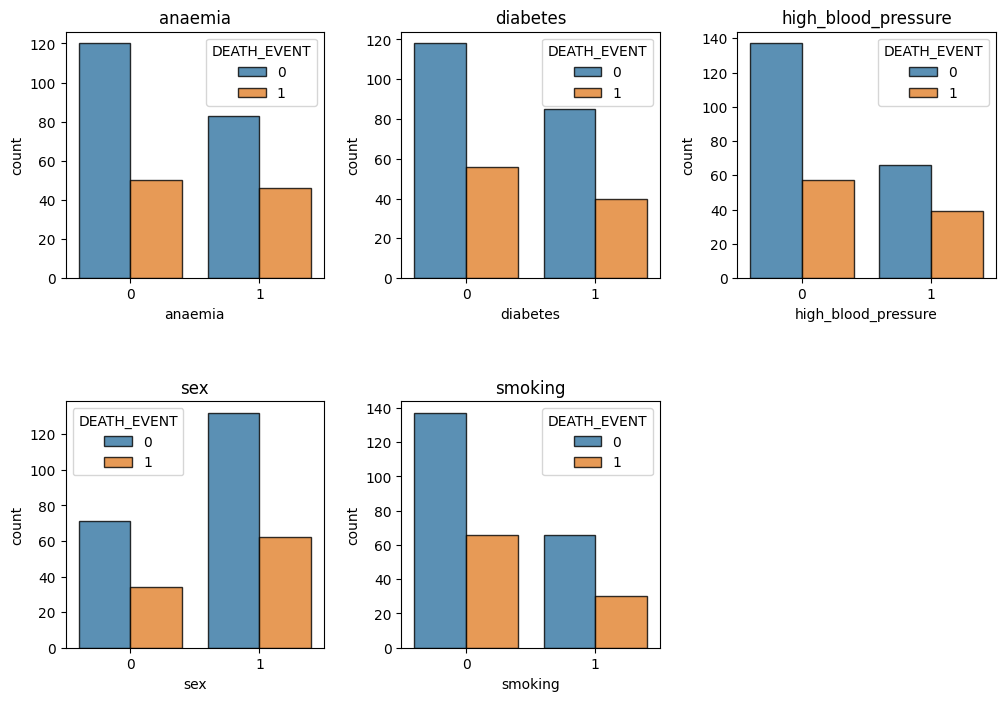

In [119]:
plt.figure(figsize=(12, 8))

num_rows = 2
num_cols = 3

for i, col in enumerate(categorical_features):

    plt.subplot(num_rows, num_cols, i+1)
    plt.title(col)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    sns.countplot(data=hf, x=col, hue="DEATH_EVENT", alpha=0.8, edgecolor="k", linewidth=1)

plt.show()

## Standardization

One important step is standardization for numerical features that is performed via the standard `sklearn` function, removing the mean and scaling to unit variance.

\begin{align}
{z = \frac{(x−\bar{x})}{\hat{\sigma}}}
\end{align}

where $\bar{x}$ is the mean of the training samples and ${\hat{\sigma}}$ is the sample standard deviation.

In [120]:
hf_norm = hf.copy()
for col in numerical_features:
    hf_norm[col] = StandardScaler().fit_transform(hf_norm[[col]])

We will generate two sets of plots side by side to compare the distribution of the `ejection fraction` feature before and after normalization:

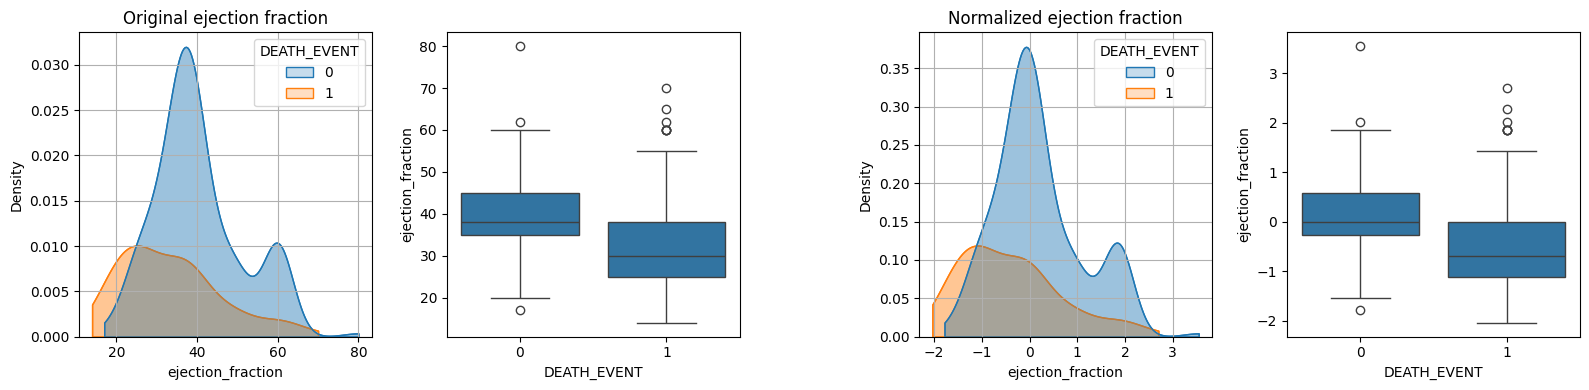

In [121]:
plt.figure(figsize=(16, 4))

gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 0.1, 1, 1])

plt.subplot(gs[0])   
plt.grid(True)
plt.title("Original ejection fraction")
sns.kdeplot(data=hf, x="ejection_fraction", hue="DEATH_EVENT", label="alive", fill=True, cut=0)
sns.kdeplot(data=hf, x="ejection_fraction", hue="DEATH_EVENT", label="dead", fill=True, cut=0)

plt.subplot(gs[1]) 
sns.boxplot(data=hf, y="ejection_fraction", x="DEATH_EVENT")  

plt.subplot(gs[3])  
plt.grid(True)
plt.title("Normalized ejection fraction")
sns.kdeplot(data=hf_norm, x="ejection_fraction", hue="DEATH_EVENT", label="alive", fill=True, cut=0)
sns.kdeplot(data=hf_norm, x="ejection_fraction", hue="DEATH_EVENT", label="dead", fill=True, cut=0)

plt.subplot(gs[4])
sns.boxplot(data=hf_norm, y="ejection_fraction", x="DEATH_EVENT")

plt.tight_layout()

## Correlation matrix

To see how features are correlated is useful to look at the correlation matrix that is a matrix in which are showed the correlation values of each couple of features according to the **Pearson's correlation coefficient**:

${\displaystyle \rho _{X_1,X_2}={\frac {\operatorname {cov} (X_1,X_2)}{\sigma _{X_1}\sigma _{X_2}}}}$ 

Where $cov$ stands for **the covariance measure**, being the mean of the product of the differences between each feature and their respective means:

${\displaystyle \operatorname {cov} (X_1,X_2)=\operatorname {E}{{\big [}(X_1-\operatorname {E} [X_1])(X_2-\operatorname {E} [X_2]){\big ]}},}$

That is computed for every pair of features ${X_1}$ and ${X_2}$

In [122]:
all_features = categorical_features.copy()
all_features.extend(numerical_features)

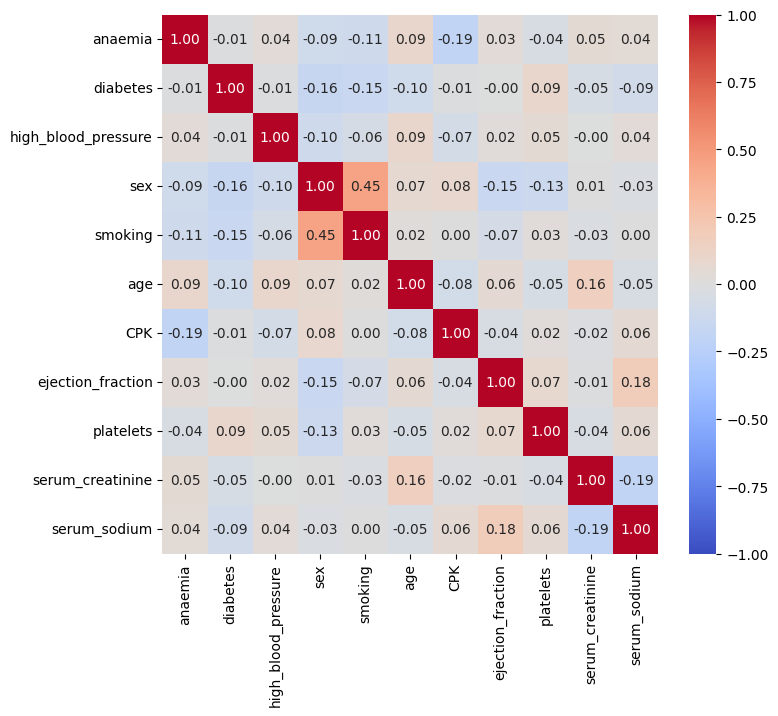

In [123]:
plt.figure(figsize=(8, 7))
sns.heatmap(hf_norm[all_features].corr(method='pearson'), vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt='.2f');

The heatmap indicates that most features have low correlation with each other, except for a slight positive correlation between `sex` and `smoking`. However, this correlation won't pose an issue during feature selection, as one of these variables will be dropped.

## Validation with Holdout Split

To validate and test our models we will use the **holdout** approach, that consists in dividing the dataset into subsets dedicated to training, validation and test.<br>
This is useful when we have lots of data. In this case we have 299 records so the same subset is used both for validation and testing.<br>

In [124]:
train_ratio = 0.75
val_ratio = 0.25

ho_train_df, ho_val_df = train_test_split(hf_norm, train_size = train_ratio, random_state=42)
unnorm_ho_train_df, unnorm_ho_val_df = train_test_split(hf, train_size = train_ratio, random_state=42)

print("Holdout split:")
print(f"Train samples: {len(ho_train_df)}")
print(f"Validation/Test samples: {len(ho_val_df)}")

Holdout split:
Train samples: 224
Validation/Test samples: 75


## Feature selection

### Mutual information

Mutual information can be useful when assessing the dependence of a feature on the target variable.
MI is always greater than 0, and higher values indicate stronger dependence.

\begin{align}
{I(X;Y) =\sum_{y \in Y}\sum_{x \in X}p_{X, Y}(x, y)log\Bigg( \frac {p_{X, Y}(x, y)}{p_X(x)p_Y(y)} \Bigg)}
\end{align}

\begin{align}
{I(X;Y) =\int_{y}\int_{x}p_{X, Y}(x, y)log\Bigg( \frac {p_{X, Y}(x, y)}{p_X(x)p_Y(y)} \Bigg)dx dy}
\end{align}


In this case, mutual information is estimated for each feature with respect to the class label `DEATH_EVENT`.
Mutual information is calculated using the `mutual_info_classif` function from `sklearn`, which, according to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html), utilizes entropy estimation from k-nearest neighbors distances.

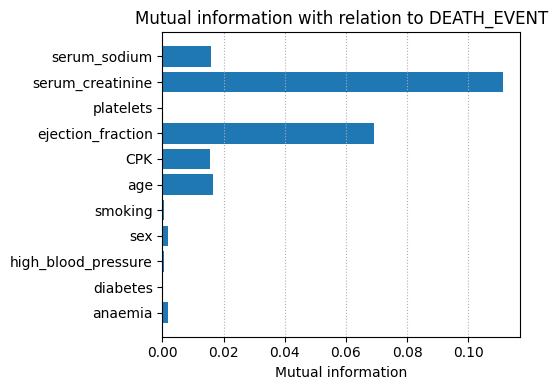

In [125]:
MI = (mutual_info_classif(ho_train_df[all_features],
                             ho_train_df["DEATH_EVENT"], n_neighbors=20,
                             discrete_features=[True, True, True, True, True, False, False, False, False, False, False],
                             random_state=42))

plt.figure(figsize=(5.4, 4))
plt.barh(y=all_features, width=MI)
plt.title("Mutual information with relation to DEATH_EVENT");
plt.xlabel("Mutual information")
plt.gca().xaxis.grid(True, linestyle=':');
plt.tight_layout();

From the plot we can say that `platelets`, `smoking`, `high_blood_pressure` and `diabetes` can be easily dropped.<br>
Altough `sex` and `anaemia` produce still very low values, they are kept.

In [126]:
all_features = ['anaemia', 'sex', 'age', 'CPK', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']

## Class imbalance

One thing to take into account is the possible class imbalance.

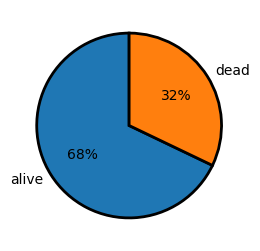

In [127]:
plt.figure(figsize=(3, 3))
plt.pie(hf["DEATH_EVENT"].value_counts(),
        labels = ["alive", "dead"],
        wedgeprops={'edgecolor':'black', 'linewidth': 2}, 
        autopct = lambda y: str(round(y))+"%",
        startangle=90);

We observe a class imbalance, though not particularly pronounced.<br>
This can leads to biased results that can be noticed by measures such as `recall`, `precision` or `f1`.<br>
To handle class imbalance it's possible to *re-balance* the dataset. We will use the Random oversampling technique.

### Random oversampling

Oversampling is a technique used to balance the class distribution by increasing the number of instances in the minority class. <br>
This is achieved by duplicating existing instances of the minority class to create a balanced dataset.

In [128]:
import pandas as pd

n_to_sample = len(ho_train_df[ho_train_df.DEATH_EVENT==0]) - len(ho_train_df[ho_train_df.DEATH_EVENT==1])
new_samples = ho_train_df[ho_train_df.DEATH_EVENT==1].sample(n_to_sample, replace=True, random_state=42)

ho_train_df_rs = pd.concat([ho_train_df, new_samples])

new_samples = unnorm_ho_train_df[unnorm_ho_train_df.DEATH_EVENT==1].sample(n_to_sample, replace=True, random_state=42)
unnorm_ho_train_df_rs = pd.concat([unnorm_ho_train_df, new_samples])

C:\Users\augus\AppData\Local\Temp\ipykernel_14776\2604888764.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ho_train_df[ho_train_df.DEATH_EVENT==1].ejection_fraction, bins=nbins)
C:\Users\augus\AppData\Local\Temp\ipykernel_14776\2604888764.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplo

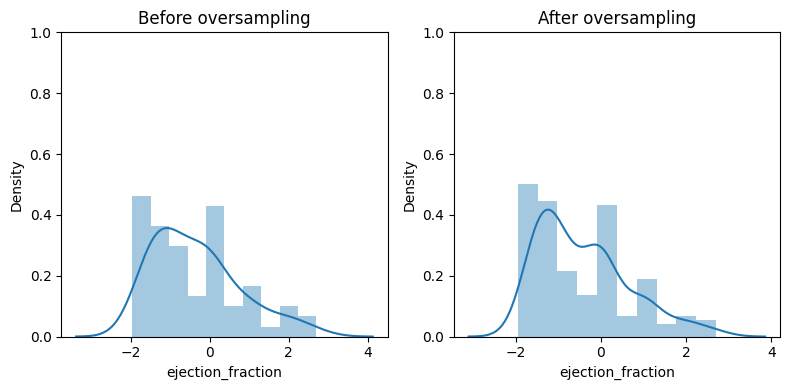

In [129]:
nbins = 10
plt.figure(figsize = (8, 4))

plt.subplot(1, 2, 1)
plt.ylim(0, 1)
plt.title("Before oversampling")
sns.distplot(ho_train_df[ho_train_df.DEATH_EVENT==1].ejection_fraction, bins=nbins)
plt.subplot(1, 2, 2)
plt.ylim(0, 1)
plt.title("After oversampling")
sns.distplot(ho_train_df_rs[ho_train_df_rs.DEATH_EVENT==1].ejection_fraction, bins=nbins);
plt.tight_layout()

# Classification models

Now will follow a series of different models used to perform classification of the `DEATH_EVENT`

* [Traditional Machine Learning Models](#Traditional_ML_models)
    * [Logistic Regression](#Logistic_regression)
    * [Random Forest](#Random_forest)
    * [XGBoost](#XGBoost)
* [Graph-Based Model](#Graph_based_models)
    * [Graph Neural Network (GCN)](#GCN)
        
All models are evaluated considering the following metrics

* ${accuracy = \frac {TP+TN}{TP+TN+FP+FN}\quad }$


* ${precision = \frac {TP}{TP+FP}\quad}$


* ${recall = \frac {TP}{TP+FN}\quad}$ 


* ${F_1 = 2 \times \frac{precision \times recall}{precision+recall}}$

## Logistic Regression


Logistic Regression is chosen for its simplicity and effectiveness in binary classification tasks. It predicts the probability of a binary outcome using a logistic function, which makes it suitable for modeling the survival of heart failure patients.

Below is the implementation of Logistic Regression on our dataset:

#### Parameters

In [188]:
c = 1
penalty = "l2"
solver = "liblinear"
multi_class = "auto"

#### Logistic regression with Oversampling

In [189]:
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                        random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])

rs_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
rs_rec = recall_score(ho_val_df["DEATH_EVENT"], pred)
rs_pre = precision_score(ho_val_df["DEATH_EVENT"], pred)
rs_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

#### Logistic regression without Oversampling

In [190]:
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                        random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])
pred = lr.predict(ho_val_df[all_features])

no_rs_acc = accuracy_score(ho_val_df["DEATH_EVENT"], pred)
no_rs_rec = recall_score(ho_val_df["DEATH_EVENT"], pred)
no_rs_pre = precision_score(ho_val_df["DEATH_EVENT"], pred)
no_rs_f1 = f1_score(ho_val_df["DEATH_EVENT"], pred)

#### Ploting the results

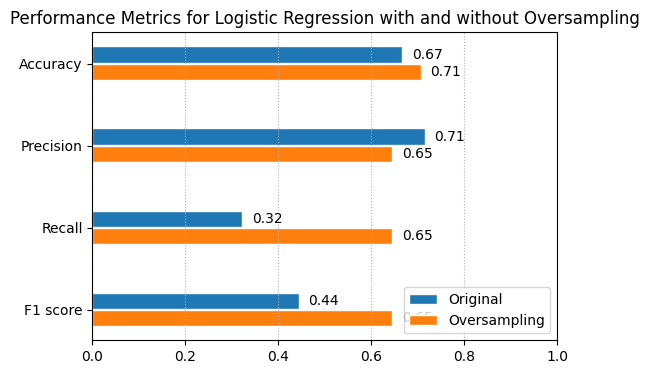

In [191]:
fig = plt.figure(figsize=(6, 4))
barWidth = 0.2
space = 0.01

bars1 = [no_rs_f1, no_rs_rec, no_rs_pre, no_rs_acc]
bars2 = [rs_f1, rs_rec, rs_pre, rs_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]

plt.barh(r2, bars1, label="Original", height=barWidth, edgecolor='white')
plt.barh(r1, bars2, label="Oversampling", height=barWidth, edgecolor='white')

plt.title("Performance Metrics for Logistic Regression with and without Oversampling")
plt.yticks([r + barWidth * 0.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy"])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')

for i in range(len(bars1)):
    plt.text(bars1[i] + 0.02, r2[i], f'{bars1[i]:.2f}', va='center')
    plt.text(bars2[i] + 0.02, r1[i], f'{bars2[i]:.2f}', va='center')

plt.legend()
plt.show()

## Random Forest

Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes for classification. It reduces overfitting and improves accuracy by averaging the results of various trees.

Below is the implementation of Random Forest on our dataset:

#### Parameters

In [192]:
max_features = 'sqrt'  # square root of the number of features
max_depth = 14
depth = range(1, max_depth)
n_trees = [5, 10, 20, 50, 100]
n_vals = len(n_trees)

#### List initialization to store results

In [193]:
rs_acc, rs_rec, rs_pre, rs_f1 = [[] for _ in range(n_vals)], [[] for _ in range(n_vals)], [[] for _ in range(n_vals)], [[] for _ in range(n_vals)]
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = [[] for _ in range(n_vals)], [[] for _ in range(n_vals)], [[] for _ in range(n_vals)], [[] for _ in range(n_vals)]

#### Random forest with and without Oversampling

In [194]:
for i, n in enumerate(n_trees):
    for d in depth:
        # Random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    random_state=42, class_weight=None)
        
        rf.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])
        pred = rf.predict(ho_val_df[all_features])
        rs_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
        rs_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
        rs_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
        rs_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))

        # Not oversampled
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    random_state=42, class_weight=None)
        
        rf.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])
        pred = rf.predict(ho_val_df[all_features])
        no_rs_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
        no_rs_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
        no_rs_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
        no_rs_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))

#### Mean values for the last set of n_trees and max_depth

In [195]:
mean_rs_acc = [np.mean(acc) for acc in rs_acc]
mean_rs_rec = [np.mean(rec) for rec in rs_rec]
mean_rs_pre = [np.mean(pre) for pre in rs_pre]
mean_rs_f1 = [np.mean(f1) for f1 in rs_f1]

mean_no_rs_acc = [np.mean(acc) for acc in no_rs_acc]
mean_no_rs_rec = [np.mean(rec) for rec in no_rs_rec]
mean_no_rs_pre = [np.mean(pre) for pre in no_rs_pre]
mean_no_rs_f1 = [np.mean(f1) for f1 in no_rs_f1]

#### Ploting the results

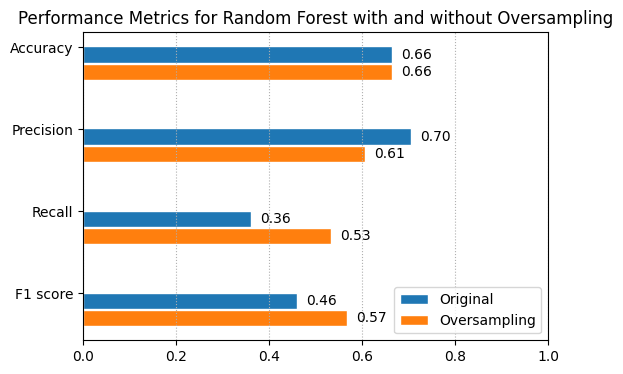

In [196]:
fig = plt.figure(figsize=(6, 4))
barWidth = 0.2
space = 0.01

bars1 = [mean_no_rs_f1[-1], mean_no_rs_rec[-1], mean_no_rs_pre[-1], mean_no_rs_acc[-1]]
bars2 = [mean_rs_f1[-1], mean_rs_rec[-1], mean_rs_pre[-1], mean_rs_acc[-1]]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]

plt.barh(r2, bars1, label="Original", height=barWidth, edgecolor='white')
plt.barh(r1, bars2, label="Oversampling", height=barWidth, edgecolor='white')

plt.title("Performance Metrics for Random Forest with and without Oversampling")
plt.yticks([r + barWidth * 1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy"])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')

for i in range(len(bars1)):
    plt.text(bars1[i] + 0.02, r2[i], f'{bars1[i]:.2f}', va='center')
    plt.text(bars2[i] + 0.02, r1[i], f'{bars2[i]:.2f}', va='center')

plt.legend(loc='lower right')
plt.show()

## XGBoost 

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

Below is the implementation of XGBoost on our dataset:

#### Parameters

In [197]:
learning_rates = [0.01, 0.05, 0.1]
max_depths = range(3, 10)
n_estimators = [50, 100, 200]
n_vals = len(n_estimators)

#### List initialization to store results

In [198]:
rs_acc, rs_rec, rs_pre, rs_f1 = [[] for _ in range(n_vals)], [[] for _ in range(n_vals)], [[] for _ in range(n_vals)], [[] for _ in range(n_vals)]
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = [[] for _ in range(n_vals)], [[] for _ in range(n_vals)], [[] for _ in range(n_vals)], [[] for _ in range(n_vals)]

#### XGBoost with and without Oversampling

In [199]:
for i, n in enumerate(n_estimators):
    for d in max_depths:
        for lr in learning_rates:
            # Random oversampling
            xgb = XGBClassifier(n_estimators=n, max_depth=d, learning_rate=lr, random_state=42)
            
            xgb.fit(ho_train_df_rs[all_features], ho_train_df_rs['DEATH_EVENT'])
            pred = xgb.predict(ho_val_df[all_features])
            rs_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
            rs_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
            rs_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
            rs_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))

            # Not oversampled
            xgb = XGBClassifier(n_estimators=n, max_depth=d, learning_rate=lr, random_state=42)
            
            xgb.fit(ho_train_df[all_features], ho_train_df['DEATH_EVENT'])
            pred = xgb.predict(ho_val_df[all_features])
            no_rs_acc[i].append(accuracy_score(ho_val_df["DEATH_EVENT"], pred))
            no_rs_rec[i].append(recall_score(ho_val_df["DEATH_EVENT"], pred))
            no_rs_pre[i].append(precision_score(ho_val_df["DEATH_EVENT"], pred))
            no_rs_f1[i].append(f1_score(ho_val_df["DEATH_EVENT"], pred))

#### The mean values for the last set of parameters

In [200]:
mean_rs_acc = [np.mean(acc) for acc in rs_acc]
mean_rs_rec = [np.mean(rec) for rec in rs_rec]
mean_rs_pre = [np.mean(pre) for pre in rs_pre]
mean_rs_f1 = [np.mean(f1) for f1 in rs_f1]

mean_no_rs_acc = [np.mean(acc) for acc in no_rs_acc]
mean_no_rs_rec = [np.mean(rec) for rec in no_rs_rec]
mean_no_rs_pre = [np.mean(pre) for pre in no_rs_pre]
mean_no_rs_f1 = [np.mean(f1) for f1 in no_rs_f1]

#### Ploting the results

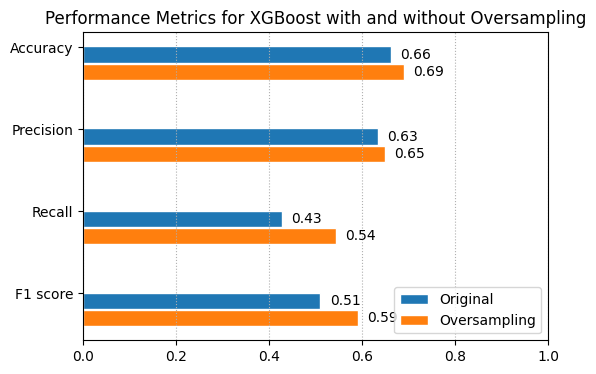

In [201]:
fig = plt.figure(figsize=(6, 4))
barWidth = 0.2
space = 0.01

bars1 = [mean_no_rs_f1[-1], mean_no_rs_rec[-1], mean_no_rs_pre[-1], mean_no_rs_acc[-1]]
bars2 = [mean_rs_f1[-1], mean_rs_rec[-1], mean_rs_pre[-1], mean_rs_acc[-1]]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]

plt.barh(r2, bars1, label="Original", height=barWidth, edgecolor='white')
plt.barh(r1, bars2, label="Oversampling", height=barWidth, edgecolor='white')

plt.title("Performance Metrics for XGBoost with and without Oversampling")
plt.yticks([r + barWidth * 1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy"])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')

for i in range(len(bars1)):
    plt.text(bars1[i] + 0.02, r2[i], f'{bars1[i]:.2f}', va='center')
    plt.text(bars2[i] + 0.02, r1[i], f'{bars2[i]:.2f}', va='center')

plt.legend(loc='lower right')
plt.show()

## Graph-Based Model

To implement a graph-based model using a dataset, such as the **Heart Failure dataset**, we need to convert the data into a graph format where nodes represent the instances (patients) and edges represent some relationships between them. For this example, we'll use a Graph Neural Network (GNN) from the PyTorch Geometric library. Below is the section for the Graph-Based Model, including **generating the graph**, **creating features**, and **building the model**.

### Introduction

**Graph Neural Networks (GNNs)** are a type of neural network designed to perform inference on data structured as graphs. GNNs have shown great promise in various applications such as social networks, recommendation systems, and biological data. In this section, we will construct a graph from **the Heart Failure dataset** and use a GNN to predict patient survival.

### Generating the Graph

Each patient will be a node, and edges will be created based on the similarity of features. We will use k-nearest neighbors (KNN) to create edges between similar nodes.

In [143]:
target = 'DEATH_EVENT'

#### Creation of edges using k-nearest neighbors

In [144]:
def create_edges(X, k=5):
    distances = euclidean_distances(X)
    knn_graph = np.argsort(distances, axis=1)[:, 1:k+1]
    edge_index = []
    for i, neighbors in enumerate(knn_graph):
        for neighbor in neighbors:
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return edge_index

#### Creation of edges for Training data with Oversampling

In [145]:
X_resampled = ho_train_df_rs[all_features].values
y_resampled = ho_train_df_rs[target].values
edge_index_rs = create_edges(X_resampled, k=5)

#### Creation of edges for Training data without Oversampling

In [146]:
X_original = ho_train_df[all_features].values
y_original = ho_train_df[target].values
edge_index_original = create_edges(X_original, k=5)

#### Creation of edges for Validation data

In [147]:
X_val = ho_val_df[all_features].values
y_val = ho_val_df[target].values
edge_index_val = create_edges(X_val, k=5)

#### Converting features and target to tensors

In [148]:
x_rs = torch.tensor(X_resampled, dtype=torch.float)
y_rs = torch.tensor(y_resampled, dtype=torch.long)
x_original = torch.tensor(X_original, dtype=torch.float)
y_original = torch.tensor(y_original, dtype=torch.long)
x_val = torch.tensor(X_val, dtype=torch.float)
y_val = torch.tensor(y_val, dtype=torch.long)


#### Creating PyTorch Geometric data objects

In [149]:
data_rs = Data(x=x_rs, edge_index=edge_index_rs, y=y_rs)
data_original = Data(x=x_original, edge_index=edge_index_original, y=y_original)
data_val = Data(x=x_val, edge_index=edge_index_val, y=y_val)

#### Visualizing the Graph

In [ ]:
node_colors = ['red' if label == 1 else 'blue' for label in y_resampled]

net = Network(notebook=True, height='750px', width='100%', cdn_resources='in_line')

for idx, (label, color) in enumerate(zip(y_resampled, node_colors)):
    net.add_node(idx, color=color)

edges = edge_index_rs.numpy().T
for edge in edges:
    if edge[0] != edge[1]:  # Skip self-loops
        net.add_edge(int(edge[0]), int(edge[1]))

net.repulsion(node_distance=200, spring_length=100)

legend_html = """
<div style="position: absolute; right: 10px; top: 10px; background-color: white; padding: 10px; border-radius: 5px; box-shadow: 0 0 10px rgba(0, 0, 0, 0.5);">
    <b>Legend:</b><br>
    <div style="display: flex; align-items: center;">
        <div style="width: 10px; height: 10px; background-color: red; margin-right: 5px;"></div>
        Death Event
    </div>
    <div style="display: flex; align-items: center; margin-top: 5px;">
        <div style="width: 10px; height: 10px; background-color: blue; margin-right: 5px;"></div>
        No Death Event
    </div>
</div>
"""
net.html += legend_html

net.show("heart_failure_graph.html")

#### Defining a Graph Convolutional Network (GCN) model 

In [151]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=16, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data_rs.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

#### Initializing model, optimizer, and loss function

In [152]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # L2 regularization
loss_fn = torch.nn.CrossEntropyLoss()

#### Early stopping parameters

In [153]:
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

#### Creating data loaders

In [154]:
train_loader_rs = DataLoader([data_rs], batch_size=1, shuffle=True)
train_loader_original = DataLoader([data_original], batch_size=1, shuffle=True)
val_loader = DataLoader([data_val], batch_size=1, shuffle=False)

#### Training the GNN model

In [155]:
def train(loader):
    model.train()
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()

#### Testing the GNN model

In [156]:
def test(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        out = model(data)
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
    return correct / total

In [157]:
train_accs_rs, val_accs_rs = [], []
train_accs_original, val_accs_original = [], []

#### Training with oversampled data

In [158]:
for epoch in range(1, 201):
    train(train_loader_rs)
    train_acc = test(train_loader_rs)
    val_acc = test(val_loader)
    train_accs_rs.append(train_acc)
    val_accs_rs.append(val_acc)
    print(f'Oversampled - Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    # Early stopping
    val_loss = loss_fn(model(next(iter(val_loader))), next(iter(val_loader)).y)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

Oversampled - Epoch: 001, Train Acc: 0.4686, Val Acc: 0.3600
Oversampled - Epoch: 002, Train Acc: 0.4843, Val Acc: 0.4000
Oversampled - Epoch: 003, Train Acc: 0.5346, Val Acc: 0.4933
Oversampled - Epoch: 004, Train Acc: 0.6006, Val Acc: 0.5067
Oversampled - Epoch: 005, Train Acc: 0.6509, Val Acc: 0.5600
Oversampled - Epoch: 006, Train Acc: 0.6887, Val Acc: 0.5733
Oversampled - Epoch: 007, Train Acc: 0.7296, Val Acc: 0.6000
Oversampled - Epoch: 008, Train Acc: 0.7453, Val Acc: 0.6267
Oversampled - Epoch: 009, Train Acc: 0.7642, Val Acc: 0.6533
Oversampled - Epoch: 010, Train Acc: 0.7516, Val Acc: 0.6667
Oversampled - Epoch: 011, Train Acc: 0.7484, Val Acc: 0.6667
Oversampled - Epoch: 012, Train Acc: 0.7516, Val Acc: 0.6800
Oversampled - Epoch: 013, Train Acc: 0.7516, Val Acc: 0.6800
Oversampled - Epoch: 014, Train Acc: 0.7516, Val Acc: 0.6667
Oversampled - Epoch: 015, Train Acc: 0.7799, Val Acc: 0.6800
Oversampled - Epoch: 016, Train Acc: 0.7767, Val Acc: 0.6800
Oversampled - Epoch: 017

#### Training with original data


In [159]:
for epoch in range(1, 201):
    train(train_loader_original)
    train_acc = test(train_loader_original)
    val_acc = test(val_loader)
    train_accs_original.append(train_acc)
    val_accs_original.append(val_acc)
    print(f'Original - Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Original - Epoch: 001, Train Acc: 0.7679, Val Acc: 0.6933
Original - Epoch: 002, Train Acc: 0.7768, Val Acc: 0.6933
Original - Epoch: 003, Train Acc: 0.7768, Val Acc: 0.6667
Original - Epoch: 004, Train Acc: 0.7679, Val Acc: 0.6800
Original - Epoch: 005, Train Acc: 0.7768, Val Acc: 0.6667
Original - Epoch: 006, Train Acc: 0.7768, Val Acc: 0.6800
Original - Epoch: 007, Train Acc: 0.7857, Val Acc: 0.6533
Original - Epoch: 008, Train Acc: 0.7812, Val Acc: 0.6400
Original - Epoch: 009, Train Acc: 0.7902, Val Acc: 0.6267
Original - Epoch: 010, Train Acc: 0.7902, Val Acc: 0.6000
Original - Epoch: 011, Train Acc: 0.7812, Val Acc: 0.6000
Original - Epoch: 012, Train Acc: 0.7812, Val Acc: 0.6133
Original - Epoch: 013, Train Acc: 0.7679, Val Acc: 0.6133
Original - Epoch: 014, Train Acc: 0.7679, Val Acc: 0.6133
Original - Epoch: 015, Train Acc: 0.7679, Val Acc: 0.6133
Original - Epoch: 016, Train Acc: 0.7679, Val Acc: 0.6000
Original - Epoch: 017, Train Acc: 0.7679, Val Acc: 0.6133
Original - Epo

#### Plotting accuracy over epochs

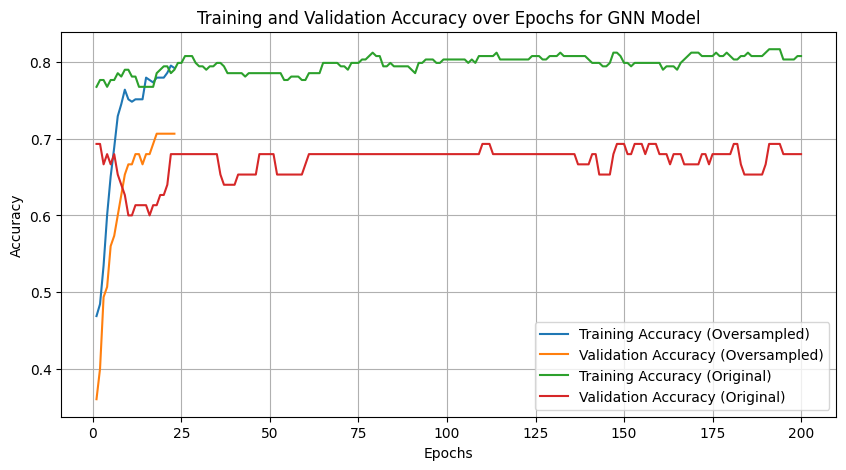

In [160]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accs_rs) + 1), train_accs_rs, label="Training Accuracy (Oversampled)")
plt.plot(range(1, len(val_accs_rs) + 1), val_accs_rs, label="Validation Accuracy (Oversampled)")
plt.plot(range(1, len(train_accs_original) + 1), train_accs_original, label="Training Accuracy (Original)")
plt.plot(range(1, len(val_accs_original) + 1), val_accs_original, label="Validation Accuracy (Original)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs for GNN Model')
plt.legend()
plt.grid(True)
plt.show()

#### Creating a function to evaluate the model and calculate performance metrics

In [227]:
def evaluate(loader):
    model.eval()
    y_true = []
    y_pred = []
    for data in loader:
        out = model(data)
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, rec, pre, f1

#### Initializing model, optimizer, and loss function 

In [228]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

#### Training and evaluating with oversampled data

In [229]:
train_accs_rs, val_accs_rs = [], []
for epoch in range(1, 201):
    train(train_loader_rs)
    train_acc = test(train_loader_rs)
    val_acc = test(val_loader)
    train_accs_rs.append(train_acc)
    val_accs_rs.append(val_acc)

rs_acc, rs_rec, rs_pre, rs_f1 = evaluate(val_loader)

#### Training and evaluating with original data

In [230]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_accs_original, val_accs_original = [], []
for epoch in range(1, 201):
    train(train_loader_original)
    train_acc = test(train_loader_original)
    val_acc = test(val_loader)
    train_accs_original.append(train_acc)
    val_accs_original.append(val_acc)

no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = evaluate(val_loader)

#### Plotting the results

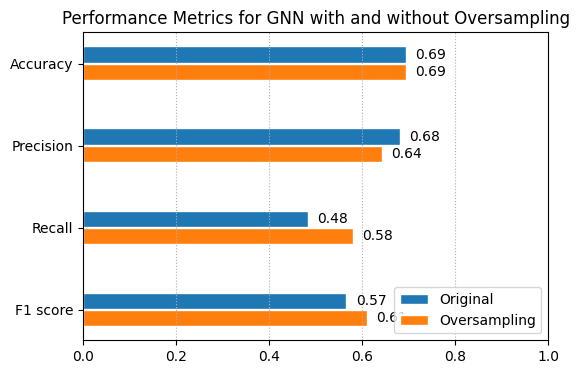

In [231]:
fig = plt.figure(figsize=(6, 4))
barWidth = 0.2
space = 0.01

bars1 = [no_rs_f1, no_rs_rec, no_rs_pre, no_rs_acc]
bars2 = [rs_f1, rs_rec, rs_pre, rs_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]

plt.barh(r2, bars1, label="Original", height=barWidth, edgecolor='white')
plt.barh(r1, bars2, label="Oversampling", height=barWidth, edgecolor='white')

plt.title("Performance Metrics for GNN with and without Oversampling")
plt.yticks([r + barWidth * 0.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy"])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')

for i in range(len(bars1)):
    plt.text(bars1[i] + 0.02, r2[i], f'{bars1[i]:.2f}', va='center')
    plt.text(bars2[i] + 0.02, r1[i], f'{bars2[i]:.2f}', va='center')

plt.legend()
plt.show()

# Results and Conclusions

In this section, we will compare the performance metrics of four different models: Logistic Regression, Random Forest, XGBoost, and Graph Neural Network (GNN). Each model was evaluated using both the original and the oversampled datasets. The key performance metrics considered are Accuracy, Precision, Recall, and F1 score.

## Logistic Regression
The Logistic Regression model's performance with and without oversampling is depicted below.

- **Accuracy**: Original: 0.67, Oversampling: 0.71
- **Precision**: Original: 0.71, Oversampling: 0.65
- **Recall**: Original: 0.32, Oversampling: 0.65
- **F1 Score**: Original: 0.44, Oversampling: 0.65

## Random Forest
The Random Forest model's performance with and without oversampling is shown below.

- **Accuracy**: Original: 0.66, Oversampling: 0.66
- **Precision**: Original: 0.70, Oversampling: 0.61
- **Recall**: Original: 0.36, Oversampling: 0.53
- **F1 Score**: Original: 0.46, Oversampling: 0.57

## XGBoost
The XGBoost model's performance with and without oversampling is illustrated below.

- **Accuracy**: Original: 0.66, Oversampling: 0.69
- **Precision**: Original: 0.63, Oversampling: 0.65
- **Recall**: Original: 0.43, Oversampling: 0.54
- **F1 Score**: Original: 0.51, Oversampling: 0.59

## Graph Neural Network (GNN)
The GNN model's performance with and without oversampling is presented below.

- **Accuracy**: Original: 0.69, Oversampling: 0.69
- **Precision**: Original: 0.68, Oversampling: 0.64
- **Recall**: Original: 0.48, Oversampling: 0.58
- **F1 Score**: Original: 0.57, Oversampling: 0.61

### Detailed Comparison

#### Accuracy
- The GNN model achieved the highest accuracy among all models both with and without oversampling.
- Logistic Regression and XGBoost also showed slight improvements in accuracy with oversampling.

#### Precision
- Logistic Regression and Random Forest showed the highest precision without oversampling, while the GNN model maintained competitive precision with and without oversampling.
- XGBoost showed consistent precision across both datasets.

#### Recall
- The GNN model demonstrated a significant improvement in recall with oversampling, similar to the other models.
- Logistic Regression showed the most dramatic increase in recall with oversampling, followed by Random Forest and XGBoost.

#### F1 Score
- The F1 score improved across all models with oversampling.
- Logistic Regression and XGBoost showed substantial increases in F1 score with oversampling.

### Conclusion
In conclusion, the Graph Neural Network (GNN) model showed promising results, particularly in terms of recall and F1 score, both with and without oversampling. This highlights its capability to comparably and sometimes better detect minority classes compared to traditional models like Logistic Regression, Random Forest, and XGBoost.

Oversampling improved the performance of all models, especially in recall and F1 score, indicating a better detection of the minority class (death events). Among the traditional models, Logistic Regression benefitted the most from oversampling.

The GNN model's performance demonstrates the potential advantages of using graph-based approaches for this type of prediction problem, providing competitive accuracy and significant improvements in recall and F1 score. Future work could explore further tuning of hyperparameters, experimenting with different graph-based models, and integrating more advanced oversampling techniques to enhance the performance further.
